In [9]:

from typing import Tuple
import json
from opensearchpy import OpenSearch
from opensearchpy.helpers import bulk
from loguru import logger

In [10]:
def get_opensearch(host: str='localhost', 
                   port: int=9200, 
                   auth: Tuple[str, str]=('admin', 'admin')
                   ) -> OpenSearch:

    #### Step 2.a: Create a connection to OpenSearch
    client = OpenSearch(
    hosts=[{'host': host, 'port': port}],
    http_compress=True,  # enables gzip compression for request bodies
    http_auth=auth,
    # client_cert = client_cert_path,
    # client_key = client_key_path,
    use_ssl=False,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False)

    return client

In [11]:
client = get_opensearch()

In [12]:
client.ping()

True

## Indexing

In [17]:
mapping_path = '/Users/americanthinker/Training/search_fundamentals_course/opensearch/bbuy_products.json'
def get_mapping(file_path: str=mapping_path):
    with open(file_path) as f:
        mapping = json.load(f)
        return mapping

In [63]:
mapping = get_mapping()
mapping

{'settings': {'index.refresh_interval': '5s'},
 'mappings': {'properties': {'sku': {'type': 'long'},
   'productID': {'type': 'integer', 'coerce': True},
   'name': {'type': 'text',
    'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}},
    'analyzer': 'english'},
   'type': {'type': 'text',
    'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
   'regularPrice': {'type': 'float'},
   'salePrice': {'type': 'float'},
   'onSale': {'type': 'boolean'},
   'salesRankShortTerm': {'type': 'integer'},
   'salesRankMediumTerm': {'type': 'integer'},
   'salesRankLongTerm': {'type': 'integer'},
   'bestSellingRank': {'type': 'integer'},
   'url': {'type': 'text',
    'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
   'categoryPath': {'type': 'text',
    'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
   'categoryPathIds': {'type': 'text',
    'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
   'categoryLeaf': {'ty

In [113]:
#client.indices.delete('bbuy_queries')

In [134]:
print(client.cat.indices(params={'v':'true'}))

health status index                                     uuid                   pri rep docs.count docs.deleted store.size pri.store.size
yellow open   full-load                                 yHVRCl33QxeTCal-WSWs-Q   1   1    1275077            0    850.1mb        850.1mb
yellow open   search_fun_bulk                           IqX_TVi3QAyyyLCM4VJmYg   1   1          4            0      8.8kb          8.8kb
yellow open   search_fun_revisited_custom_mappings      mUYsVGTGSOWQIumfCsW2aw   1   1          4            0     21.2kb         21.2kb
green  open   opensearch_dashboards_sample_data_flights t72TeXP-RLGfPu2GO5q9kg   1   0      13059            0      5.7mb          5.7mb
yellow open   bbuy_queries                              2q-9Ce5RSOuC3hBF290Znw   1   1    1865269            0    421.3mb        421.3mb
green  open   .kibana_1                                 JnrGXHSsQvq9t9oOKrLRtw   1   0         60            0     41.3kb         41.3kb



In [135]:
client.indices.get_mapping('full-load')
#client.count(index='bbuy_queries')['count']

{'full-load': {'mappings': {'properties': {'bestBuyItemId': {'type': 'integer',
     'coerce': True},
    'bestSellingRank': {'type': 'integer'},
    'categoryLeaf': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'categoryPath': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'categoryPathCount': {'type': 'integer', 'coerce': True},
    'categoryPathIds': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'class': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'classId': {'type': 'integer'},
    'customerReviewAverage': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'customerReviewCount': {'type': 'integer', 'coerce': True},
    'department': {'type': 'text',
     'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}},
    'departmentId': {'type': 'integer', '

## Queries

In [136]:
index_name = 'full-load'
def query(q: str, size: int, fields: list=['category', 'query']):
    _query = {
  'size': size,
  'query': {
    'multi_match': {
      'query': q,
      'fields': fields
    }
  }
}
    return _query

In [127]:
def search(q: str, size: int=10, full: bool=False, fields: list=['name', 'shortDescription'] ):
    resp = client.search(body = query(q, size=size, fields=fields), index = index_name)
    if full:
        return resp
    else: 
        hits = resp['hits']['hits']
        for ind, hit in enumerate(hits, 1):
            for field in fields:
                print(f'{ind}:  {field}:\t\t{hit["_source"][field]}')
        

In [133]:
search('corona', size=10, fields=['query'])

1:  query:		Corona


In [142]:
query = {
    'size': 0,
    'query': {
        "match_all": {}
    },
    'aggs': {
        "price": {
            "range": {
                "field": "regularPrice",
                "ranges": [
                    {
                        "to": 2.5
                    },
                    {
                        "from":2.5,
                        "to": 5
                    },
                    {
                        "from": 5,
                        "to": 20
                    },
                    {
                        "from": 20,
                        "to": 100
                    },
                    {
                        "from":100,
                        "to":500
                    },
                    {
                        "from": 500
                    }
                ]
            }
        }
    }
}

response = client.search(
body = query,
index = index_name
)

In [205]:
user_query = 'chocolate ice cream'
sortDir='desc'
filters = []

In [229]:
query_obj = {
        'size': 10,
        "query": {
            "bool": {
                "must": {
                        "query_string": {
                            "query": user_query,
                            "fields": ["name", "shortDescription", "longDescription"],
                            "phrase_slop": 3
                                        }
                #         },
                # "filter": {
                #         "terms": {"name": filters}
                #           }
                }}},   
        "aggs": {
            "regularPrice": {
                "range": {
                        "field": "regularPrice",
                        "ranges": 
                            [
                                {
                                    "to": 5
                                },
                                {
                                    "from": 5,
                                    "to": 20
                                },
                                {
                                    "from": 20,
                                }
                            ]
                        }
                            },
            "department": {
                "terms": {
                    "field": "department.keyword",
                    "size": 10,
                    "min_doc_count": 0
                }
                          },
            "missing_images": {
                "missing": {"field": "image.keyword"}
                              },
        "highlight": {
            "fields": {
                "name": {},
                "shortDescription": {},
                "longDescription": {}
                      }
                    },
        "sort": [
            {"regularPrice": {"order": sortDir}},
            {"name.keyword": {"order": sortDir}}
                    ]
            }

SyntaxError: unexpected EOF while parsing (1546174857.py, line 56)

In [227]:
response = client.search(body = query_obj, index = index_name)

RequestError: RequestError(400, 'search_phase_execution_exception', 'Text fields are not optimised for operations that require per-document field data like aggregations and sorting, so these operations are disabled by default. Please use a keyword field instead. Alternatively, set fielddata=true on [department] in order to load field data by uninverting the inverted index. Note that this can use significant memory.')

In [221]:
response

{'took': 8,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 3906, 'relation': 'eq'},
  'max_score': None,
  'hits': [{'_index': 'full-load',
    '_id': 'q5iKWYEBZ2ifyqU-r6-W',
    '_score': None,
    '_source': {'sku': ['8907855'],
     'productId': ['1213046785163'],
     'name': ['KitchenAid - Architect Series II 29.7 Cu. Ft. Built-In Side-by-Side Refrigerator - Stainless-Steel'],
     'type': ['HardGood'],
     'regularPrice': ['8499.99'],
     'salePrice': ['8499.99'],
     'onSale': ['false'],
     'salesRankShortTerm': [],
     'salesRankMediumTerm': [],
     'salesRankLongTerm': [],
     'bestSellingRank': [],
     'url': [],
     'categoryPath': ['Best Buy',
      'Appliances',
      'Refrigerators',
      'Side-by-Side Refrigerators'],
     'categoryPathIds': ['cat00000',
      'abcat0900000',
      'abcat0901000',
      'abcat0901005'],
     'categoryLeaf': ['abcat0901005'],
     'categoryPathCount': 4.0,

In [157]:
buckets = response['aggregations']['price']['buckets']

In [158]:
counts = [d['doc_count'] for d in buckets]

In [160]:
keys = [d['key'] for d in buckets]

In [171]:
df = pd.DataFrame(docs, index=keys)

In [170]:
import matplotlib.pyplot as plt

<AxesSubplot:>

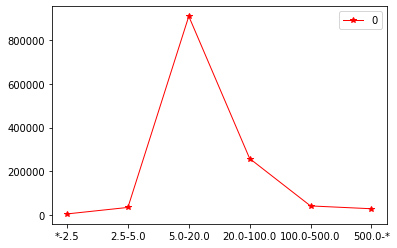

In [177]:
df.plot(color='red', linewidth=1, marker='*')